In [79]:
import numpy as np
import numpy.ma as ma

from astropy.table import QTable

import dynesty
from dynesty import plotting as dyplot

import emcee
import corner

import sys
sys.path.insert(1,"/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
from DRP_rotation_curve import extract_data
from DRP_vel_map_functions import model_vel_map, vel_logL_BB, logL_BB, deproject_spaxel
#from DRP_vel_map_plottingFunctions import plot_rot_curve

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

# Sample galaxy properties

In [80]:
gal_ID = '7443-12705'
#gal_ID = '8486-12701'

manga_plate, manga_IFU = gal_ID.split('-')
gal_filename = VEL_MAP_FOLDER + manga_plate + '/' + manga_IFU + '/manga-' + gal_ID + '-MAPS-HYB10-GAU-MILESHC.fits.gz'

In [81]:
Ha_vel, Ha_vel_ivar, Ha_vel_mask, r_band, r_band_ivar = extract_data(gal_filename)

mr_band = ma.array(r_band, mask=Ha_vel_mask)
mHa_vel = ma.array(Ha_vel, mask=Ha_vel_mask)
mHa_vel_ivar = ma.array(Ha_vel_ivar, mask=Ha_vel_mask)

In [82]:
oneD_fit_file = '../spirals/DRPall-master_file_30.txt'

oneD_fit_parameters = QTable.read(oneD_fit_file, format='ascii.ecsv')

gal_oneD_fit_parameters_boolean = np.logical_and(oneD_fit_parameters['MaNGA_plate'] == int(manga_plate), 
                                                 oneD_fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_oneD_fit_parameters_row = oneD_fit_parameters[gal_oneD_fit_parameters_boolean]

In [90]:
i_angle = np.arccos(gal_oneD_fit_parameters_row['ba'][0])
center = np.unravel_index(ma.argmax(mr_band), mr_band.shape)
v_sys = mHa_vel[center]
phi = gal_oneD_fit_parameters_row['phi'][0].value*np.pi/180
v_max = gal_oneD_fit_parameters_row['avg_v_max'][0].value
r_turn = gal_oneD_fit_parameters_row['avg_r_turn'][0].value
alpha = gal_oneD_fit_parameters_row['avg_alpha'][0]

# Find spaxel along semi-major axis
delta_x = int(center[1]*0.5)
delta_y = int(delta_x/np.tan(phi))
semi_major_axis_spaxel = tuple(np.subtract(center, (-delta_y, delta_x)))

# Check value along semi-major axis
if mHa_vel[semi_major_axis_spaxel] < 0:
    phi_guess = phi + np.pi
else:
    phi_guess = phi

pos_params = [v_sys, i_angle, center[0], center[1], phi_guess]
vel_params = [v_max, r_turn, alpha]
best_fit_params = pos_params + vel_params
'''
best_fit_values = {'v_sys':v_sys,
                   'ba':gal_oneD_fit_parameters_row['ba'][0],
                   'x0':center[0],
                   'y0':center[1],
                   'phi':phi_guess,
                   'r_turn':r_turn,
                   'v_max':v_max,
                   'alpha':alpha}
''';

In [84]:
map_shape = mHa_vel.shape

In [85]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

MANGA_FIBER_DIAMETER = 2*(1/60)*(1/60)*(np.pi/180) # angular fiber diameter (2") in radians
MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)  # spaxel size (0.5") in radians


dist_to_galaxy_Mpc = c*gal_oneD_fit_parameters_row['redshift'][0]/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

pix_scale_factor = dist_to_galaxy_kpc*np.tan(MANGA_SPAXEL_SIZE)

# Functions for dynesty sampler

In [58]:
def uniform(a, b, u):
    """Given u in [0,1], return a uniform number in [a,b]."""
    return a + (b-a)*u


def jeffreys(a, b, u):
    """Given u in [0,1], return a Jeffreys random number in [a,b]."""
    return a**(1-u) * b**u


def prior_xforBB(u):
    """
    Priors for the parameters of the BB velocity curve model. 
    Required by the dynesty sampler.
    
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
        
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    v_sys    = uniform(-300, 300, u[0])
    i_angle  = uniform(0, np.pi, u[1])
    i_center = jeffreys(0, 74, u[2])
    j_center = jeffreys(0, 74, u[3])
    phi      = uniform(-np.pi, np.pi, u[4])
    v_max    = uniform(1., 1e5, u[5])
    r_turn   = uniform(0.1, 100., u[6])
    alpha    = uniform(np.nextafter(0, 1), 100., u[7])
    
    return v_sys, i_angle, i_center, j_center, phi, v_max, r_turn, alpha


def prior_xforBB_vel(u):
    """
    Priors for the parameters of the BB velocity curve model. 
    Required by the dynesty sampler.
    
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
        
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    v_max    = uniform(1., 1e5, u[0])
    r_turn   = uniform(0.1, 100., u[1])
    alpha    = uniform(np.nextafter(0, 1), 100., u[2])
    
    return v_max, r_turn, alpha

# Nested sampler

In [10]:
dsampler = dynesty.DynamicNestedSampler(vel_logL_BB, prior_xforBB_vel, ndim=3,
                                        logl_args=(pos_params, pix_scale_factor, mHa_vel, mHa_vel_ivar),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

0it [00:00, ?it/s]Traceback (most recent call last):
  File "/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/DRP_vel_map_functions.py", line 539, in vel_logL_BB
    lambda1 = model_vel_map(params, vel_map.shape, pix_scale, 'BB')
  File "/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/DRP_vel_map_functions.py", line 234, in model_vel_map
    r, theta[i,j] = deproject_spaxel((i,j), center, phi, i_angle)
KeyboardInterrupt
0it [00:23, ?it/s]

Exception while calling loglikelihood function:
  params: [7.60733950e+04 4.35941553e+01 8.44527961e+01]
  args: ([-11.739962, 1.0683978716829448, 37, 37, 0.6447036817356814], 0.4685401594333536, masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32), masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
    

KeyboardInterrupt: 

# MCMC

In [87]:
def vel_log_prior(pars):
    v_max, r_turn, alpha = pars
    if (1 < v_max < 1e5) and (0.1 < r_turn < 100) and (0 < alpha < 100):
        return 0.0
    return -np.inf


def vel_log_prob(vel_pars, pos_pars, scale, vel, vel_ivar):
    lp_vel = vel_log_prior(vel_pars)
    if not np.isfinite(lp_vel):
        return -np.inf
    return lp_vel + vel_logL_BB(vel_pars, pos_pars, scale, vel, vel_ivar)


def log_prior(pars):
    v_sys, i_angle, i_center, j_center, phi, v_max, r_turn, alpha = pars
    if (-100 < v_sys < 100) and (0 < i_angle < 0.5*np.pi) and (0 < i_center < 72) and (0 < j_center < 72) and (1 < v_max < 1e5) and (0.1 < r_turn < 100) and (0 < alpha < 100):
        return 0.0
    return -np.inf


def log_prob(pars, scale, vel, vel_ivar):
    lp = log_prior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logL_BB(pars, scale, vel, vel_ivar)

## Run MCMC w/ 1D seeds

Run the MCMC with 32 "walkers", fitting only the velocity parameters.  Seed the walkers using either the old 1D solution or the initial guesses as defined below.

In [60]:
v_max_index = np.unravel_index(ma.argmax(mHa_vel), mHa_vel.shape)
v_max_guess = mHa_vel[v_max_index]/np.sin(i_angle)

In [61]:
r_turn_guess_spaxels,_ = deproject_spaxel(v_max_index, center, phi, i_angle)
r_turn_guess_kpc = 0.5*r_turn_guess_spaxels*pix_scale_factor

In [62]:
alpha_guess = 1

In [63]:
vel_guesses = np.array([v_max_guess, r_turn_guess_kpc, alpha_guess])

In [64]:
#pos = vel_params + 1e-4*np.random.randn(32,3)
pos = vel_guesses + np.random.randn(32,3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                vel_log_prob, 
                                args=(pos_params, pix_scale_factor, mHa_vel, mHa_vel_ivar))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [5:58:51<00:00,  4.31s/it]  


#### Plot the chains

<IPython.core.display.Javascript object>


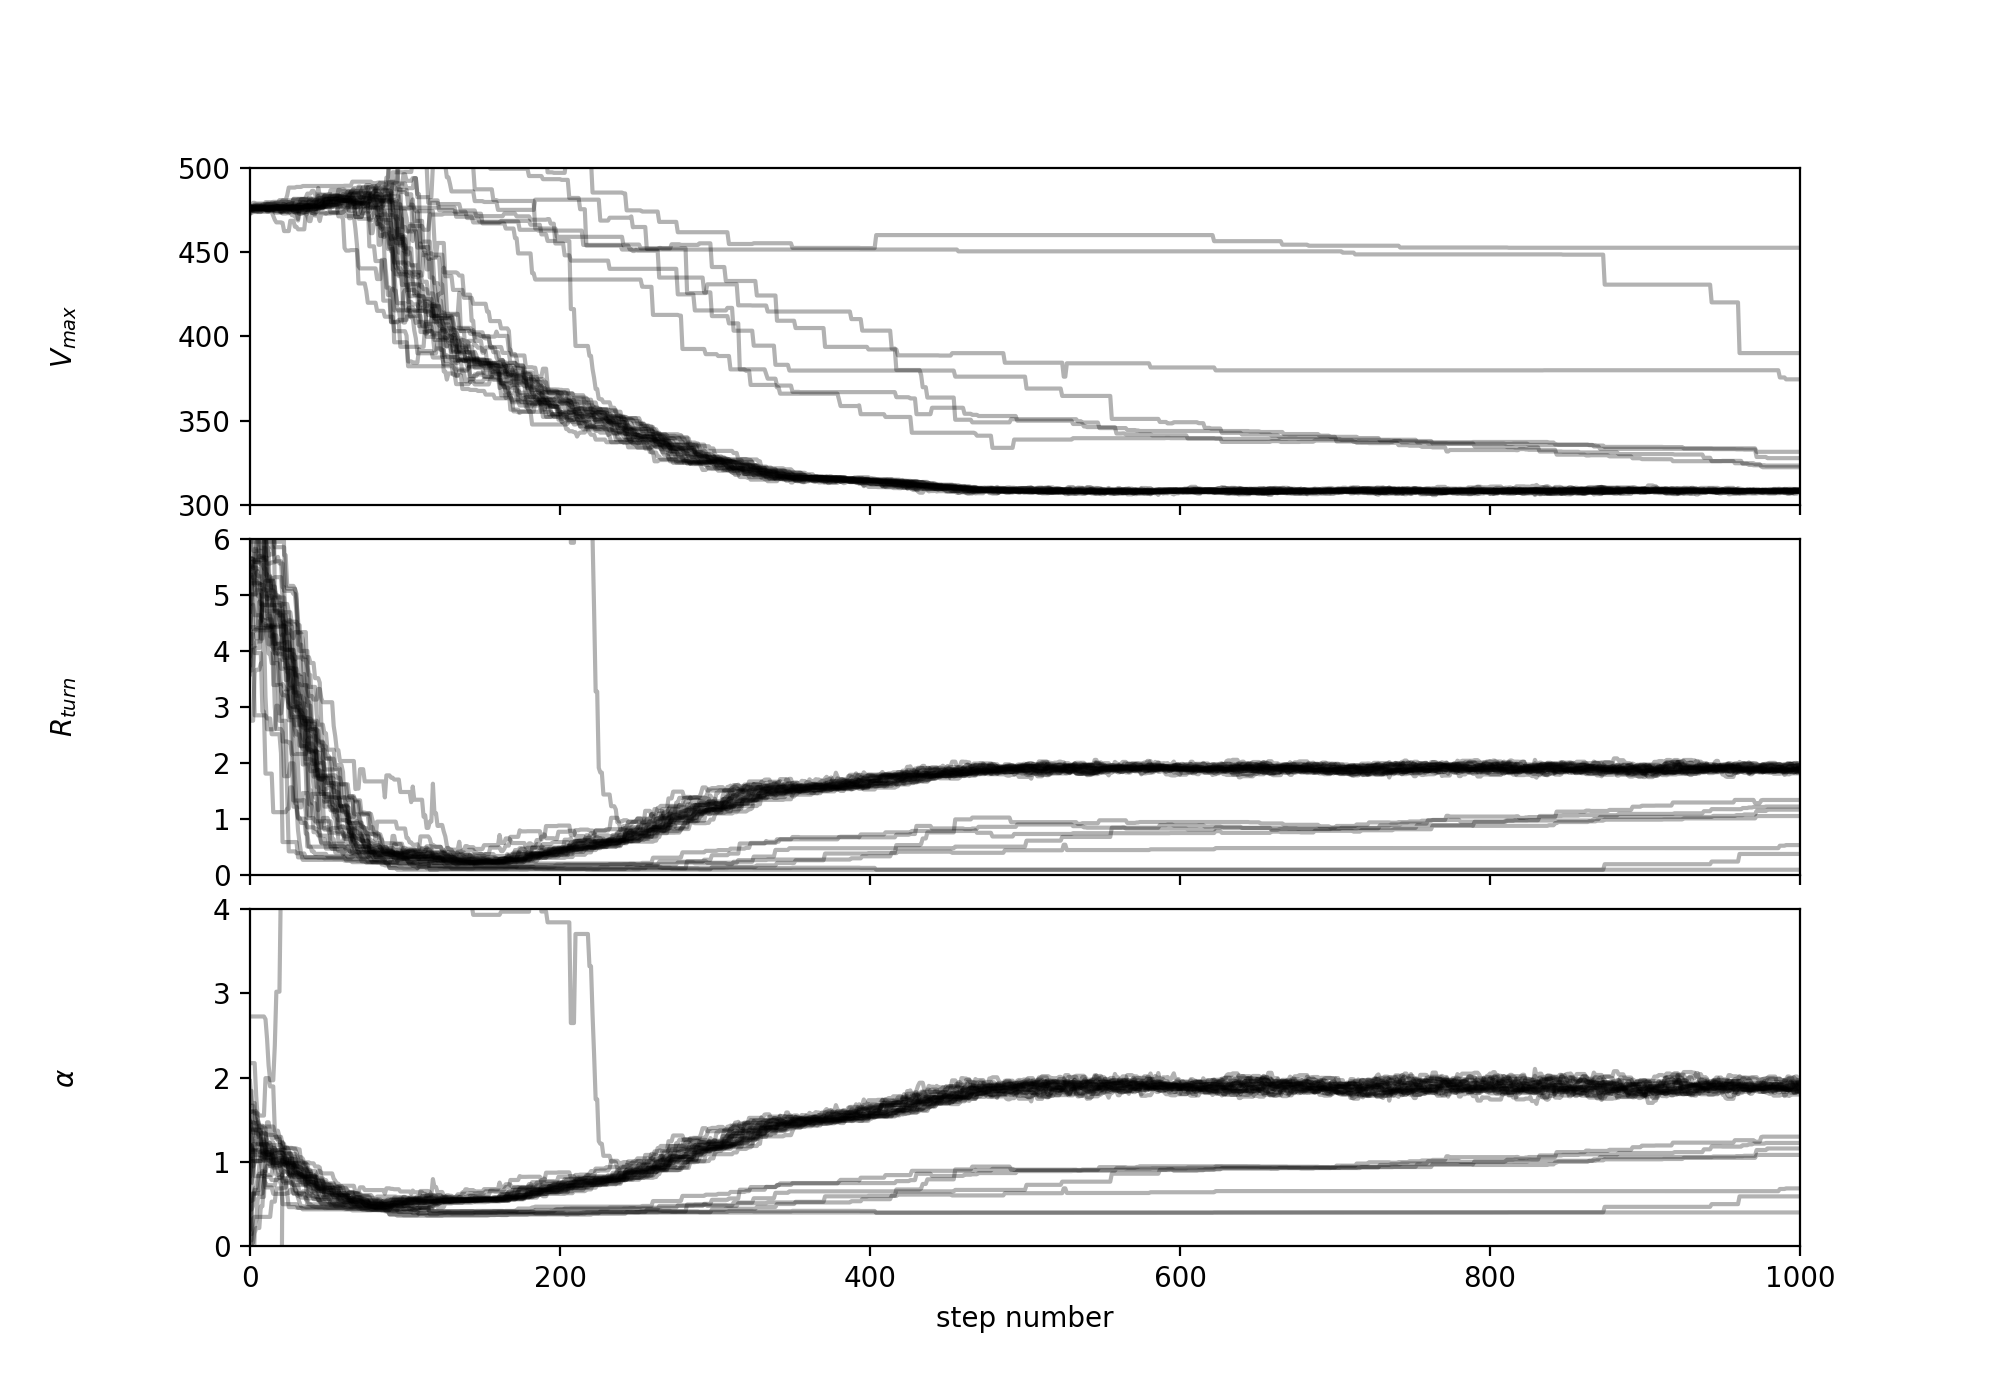

In [68]:
fig, axes = plt.subplots(3,1, figsize=(10, 7), sharex=True,
                         gridspec_kw={'hspace':0.1})
samples = sampler.get_chain()

labels_display = [r'$V_{max}$', r'$R_{turn}$', r'$\alpha$']
yrange = [(300,500), (0,6), (0,4)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:1000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,1000), ylim=yrange[i], ylabel=labels_display[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number');
#fig.tight_layout()

#### Generate a corner plot

Discard the first 100 samples, thin by half of the autocorrelation time, and flatten.

In [69]:
#flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
flat_samples = sampler.get_chain(discard=500, flat=True)

In [70]:
labels = ['v_max', 'r_turn', 'alpha']
for i, label in enumerate(labels):
    x = np.median(flat_samples[:,i])
    x16, x84 = np.percentile(flat_samples[:,i], [16,84])
    dlo = x - x16
    dhi = x84 - x
    print('{:3s} = {:5.2f} + {:4.2f} - {:4.2f}'.format(label, x, dhi, dlo))
    print('    = ({:5.2f}, {:5.2f})'.format(x16, x84))

v_max = 308.39 + 1.14 - 0.81
    = (307.58, 309.53)
r_turn =  1.90 + 0.05 - 0.07
    = ( 1.83,  1.95)
alpha =  1.89 + 0.06 - 0.08
    = ( 1.81,  1.95)


<IPython.core.display.Javascript object>


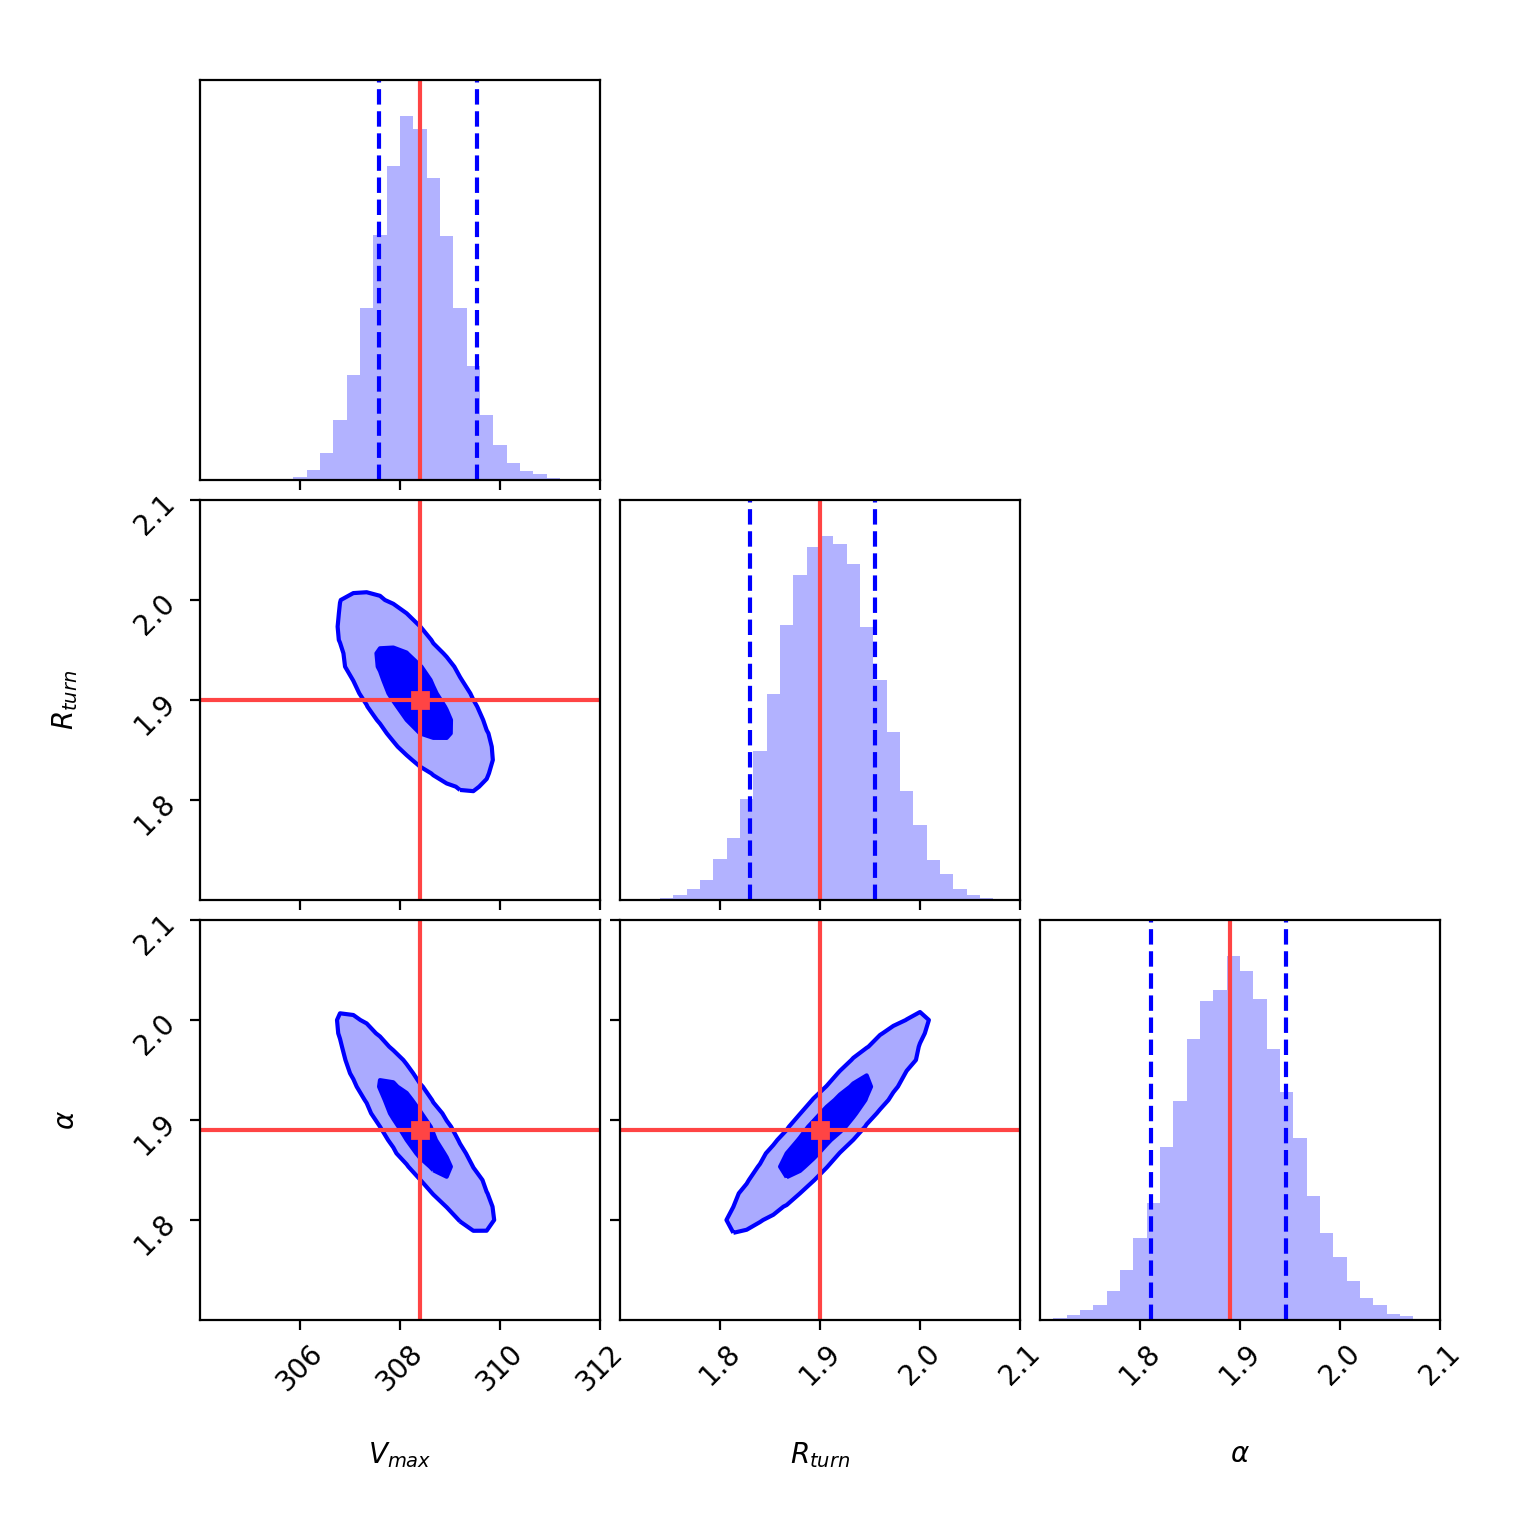

In [73]:
fig = corner.corner(flat_samples, labels=labels_display,
                    range=[(304,312), (1.7,2.1), (1.7,2.1)], bins=30, #smooth=1,
                    truths=[308.39, 1.90, 1.89], truth_color='#ff4444',
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    color='blue', plot_datapoints=False,
                    fill_contours=True);

In [74]:
model_map_BB = model_vel_map(np.concatenate([pos_params, [308.39, 1.90, 1.89]]), 
                             map_shape, 
                             pix_scale_factor, 
                             'BB')

<IPython.core.display.Javascript object>


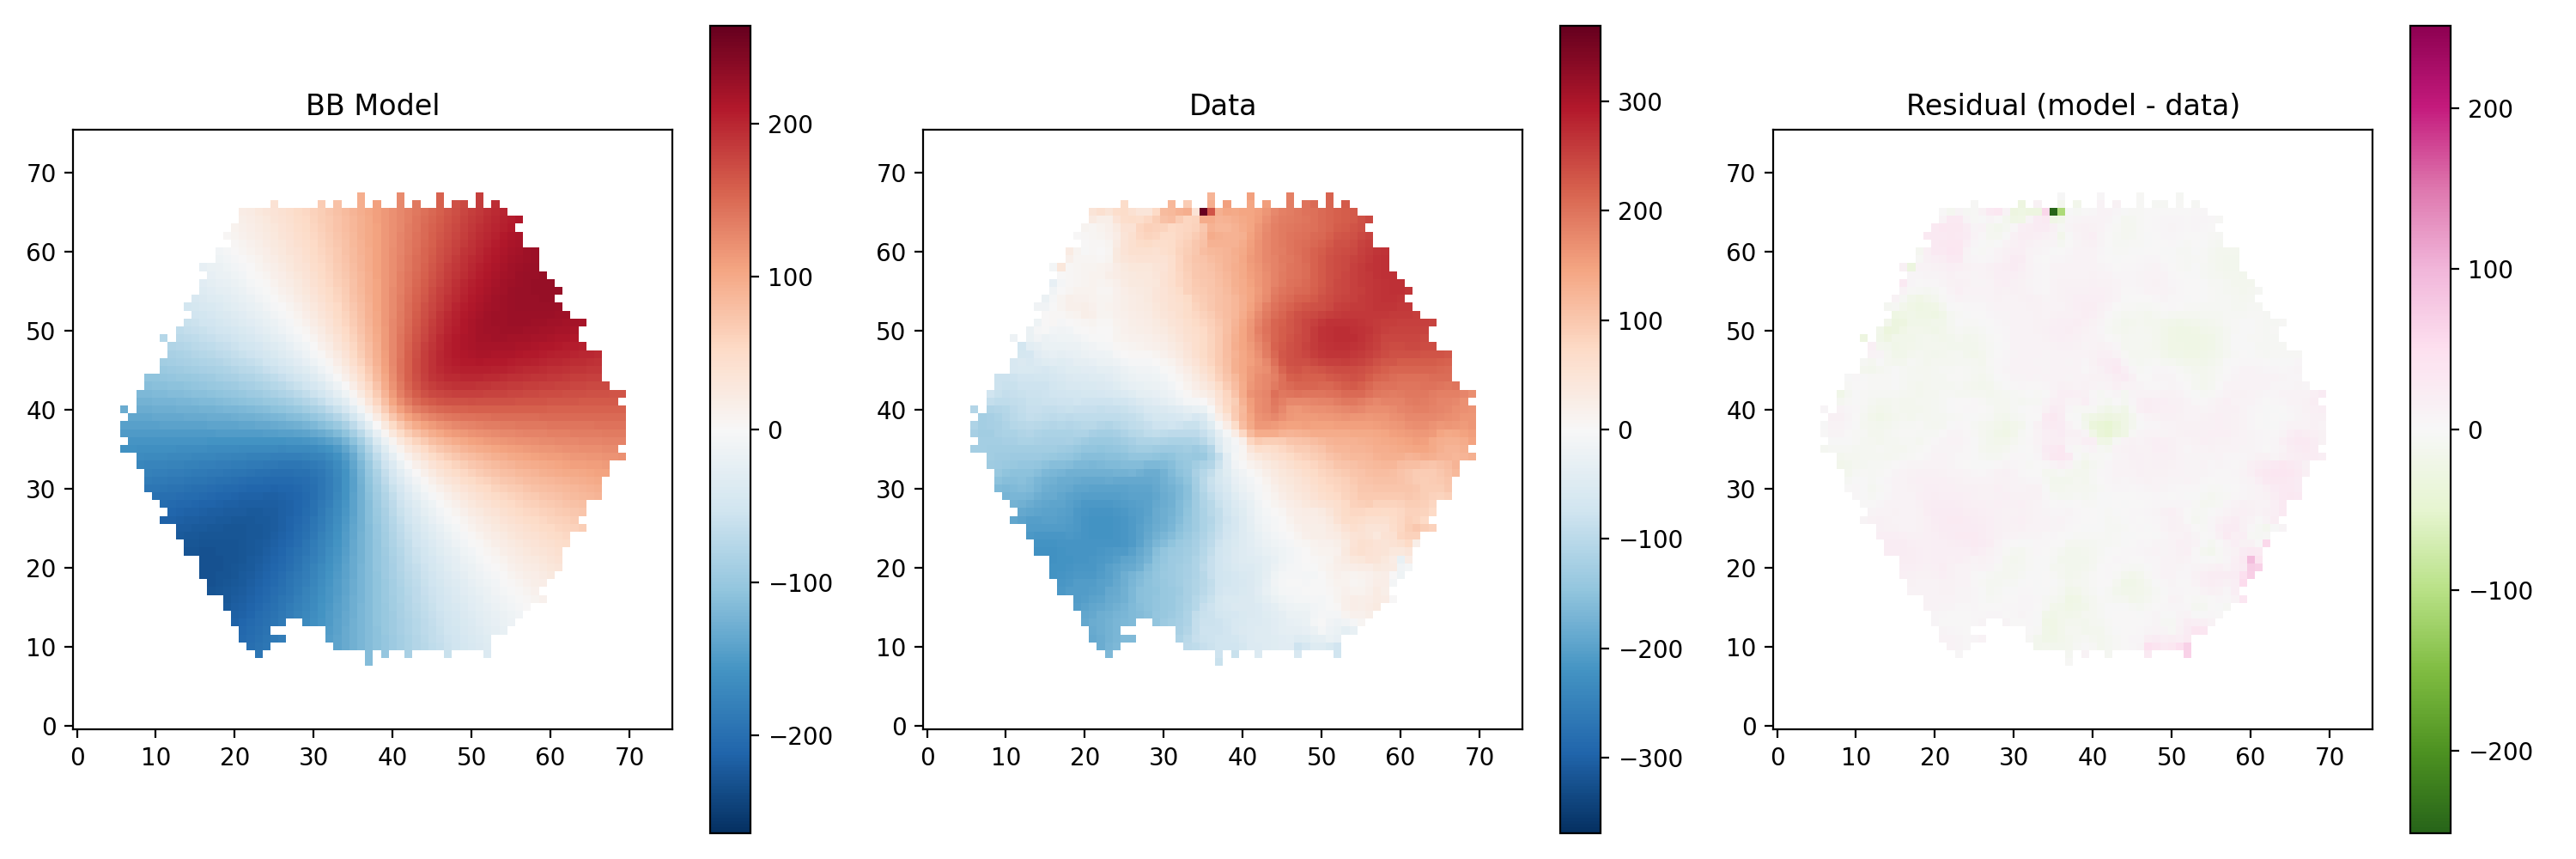

In [75]:
plt.figure(figsize=(15,5))

plt.subplot(131)
extreme1 = np.max(np.abs(model_map_BB))
plt.imshow(ma.array(model_map_BB - v_sys, mask=mHa_vel.mask), 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-extreme1, 
           vmax=extreme1)
plt.colorbar()
plt.title('BB Model')

plt.subplot(132)
extreme2 = np.max(np.abs(mHa_vel))
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme2, vmax=extreme2)
plt.colorbar()
plt.title('Data')

plt.subplot(133)
map_max = np.max(np.abs(model_map_BB - mHa_vel))
plt.imshow(model_map_BB - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-map_max, vmax=map_max)
plt.colorbar()
plt.title('Residual (model - data)')

plt.tight_layout();

## Run MCMC with random seeds

Generate the MCMC samples again but instead of seeding near the 1D fit values, instead uniformly distribute the seeds in the 3D parameter space.

In [24]:
pos = np.random.uniform(low=[1., 0.1, 0.], high=[1e5, 100, 100], size=(32,3))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                vel_log_prob, 
                                args=(pos_params, pix_scale_factor, mHa_vel, mHa_vel_ivar))
sampler.run_mcmc(pos, 5000, progress=True);

 10%|▉         | 480/5000 [23:50<3:48:02,  3.03s/it]/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in double_scalars
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))
100%|██████████| 5000/5000 [5:09:57<00:00,  3.72s/it]  


<IPython.core.display.Javascript object>


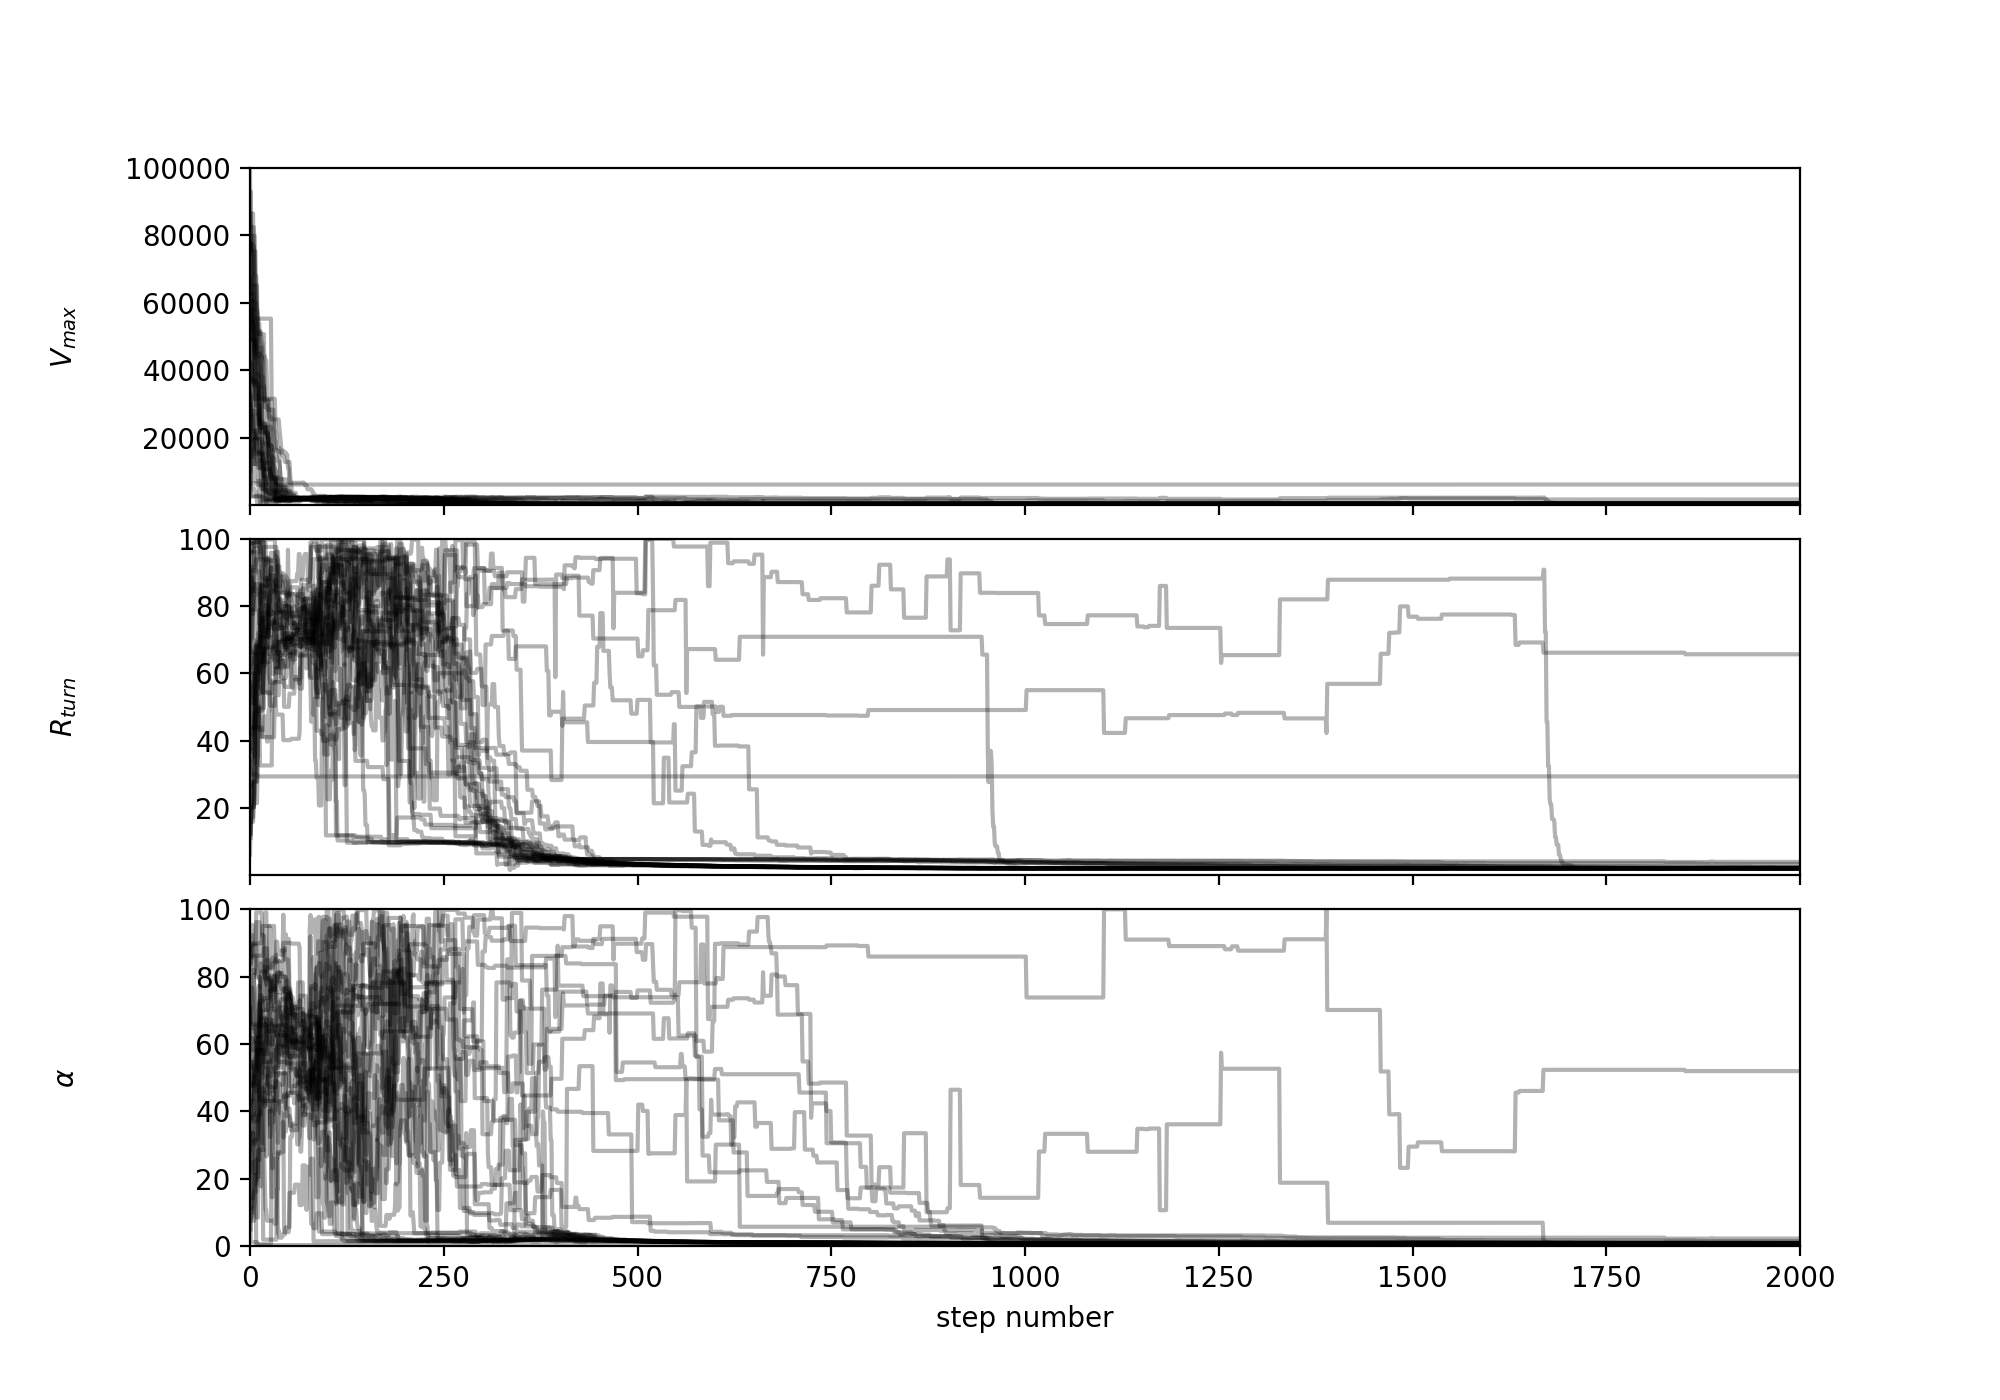

In [25]:
fig, axes = plt.subplots(3,1, figsize=(10, 7), sharex=True,
                         gridspec_kw={'hspace':0.1})
samples = sampler.get_chain()

labels_display = [r'$V_{max}$', r'$R_{turn}$', r'$\alpha$']
yrange = [(1.,1e5), (0.1,100), (0,100)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:2000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,2000), ylim=yrange[i], ylabel=labels_display[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number');

In [26]:
good_walkers = sampler.acceptance_fraction > 0

<IPython.core.display.Javascript object>


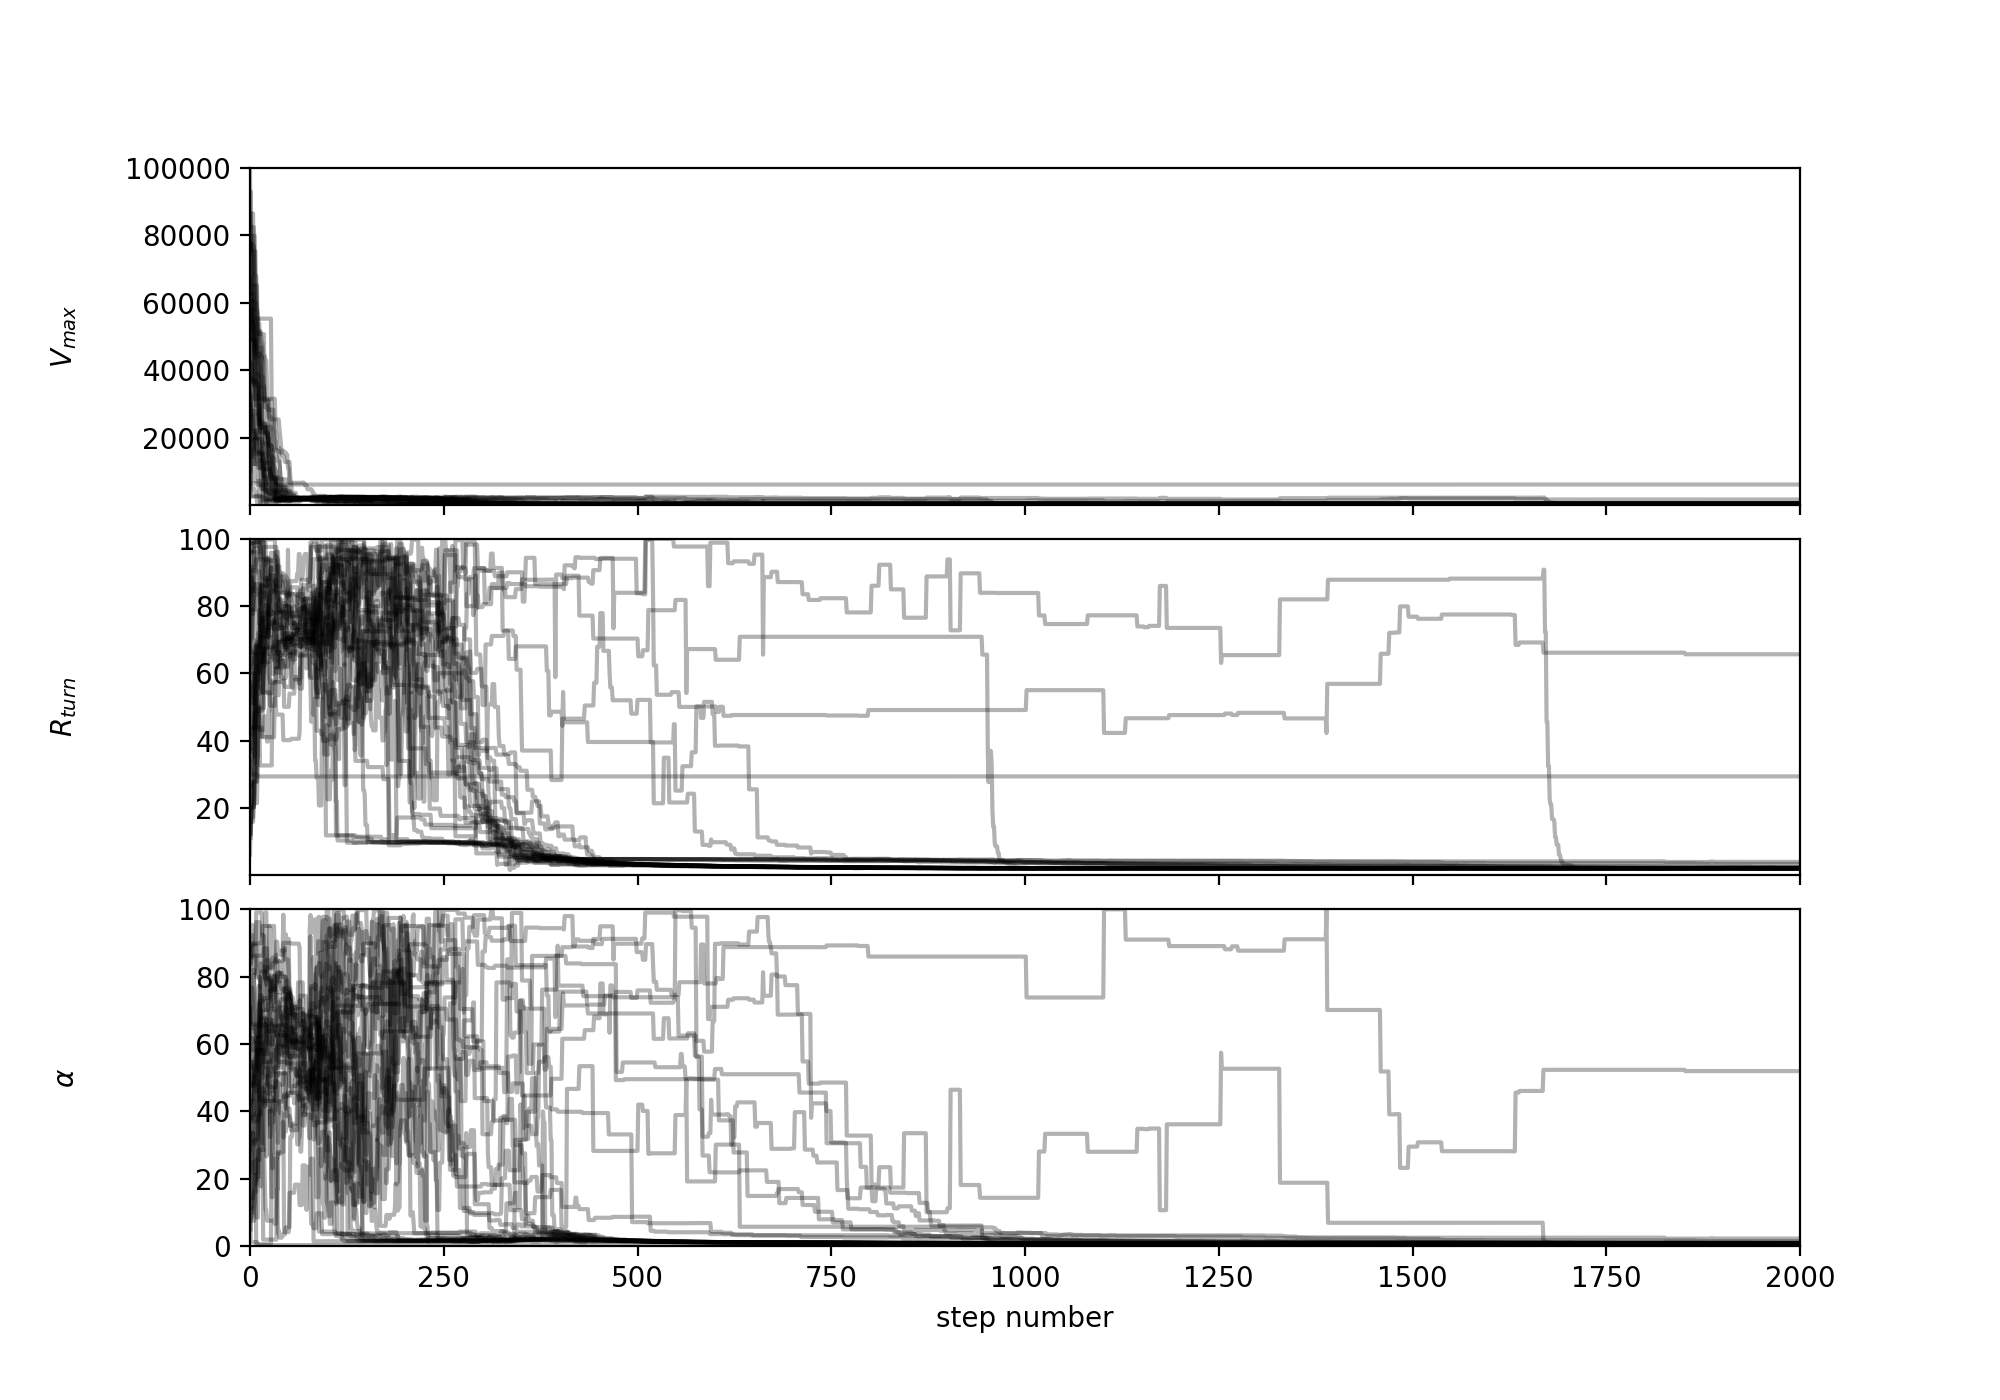

In [27]:
fig, axes = plt.subplots(3,1, figsize=(10, 7), sharex=True,
                         gridspec_kw={'hspace':0.1})
rand_samples = sampler.get_chain()[:,good_walkers,:]

labels_display = [r'$V_{max}$', r'$R_{turn}$', r'$\alpha$']
yrange = [(1.,1e5), (0.1,100), (0,100)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(rand_samples[:2000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,2000), ylim=yrange[i], ylabel=labels_display[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number');

In [28]:
rand_samples = sampler.get_chain(discard=1000)[:,good_walkers,:]
ns, nw, nd = rand_samples.shape
flat_rand_samples = rand_samples.reshape(ns*nw, nd)

In [29]:
labels = ['v_max', 'r_turn', 'alpha']
for i, label in enumerate(labels):
    x = np.median(flat_rand_samples[:,i])
    x16, x84 = np.percentile(flat_rand_samples[:,i], [16,84])
    dlo = x - x16
    dhi = x84 - x
    print('{:3s} = {:5.2f} + {:4.2f} - {:4.2f}'.format(label, x, dhi, dlo))
    print('    = ({:5.2f}, {:5.2f})'.format(x16, x84))

v_max = 316.97 + 2.89 - 2.96
    = (314.01, 319.86)
r_turn =  2.25 + 0.20 - 0.04
    = ( 2.20,  2.45)
alpha =  0.85 + 0.02 - 0.02
    = ( 0.83,  0.87)


<IPython.core.display.Javascript object>


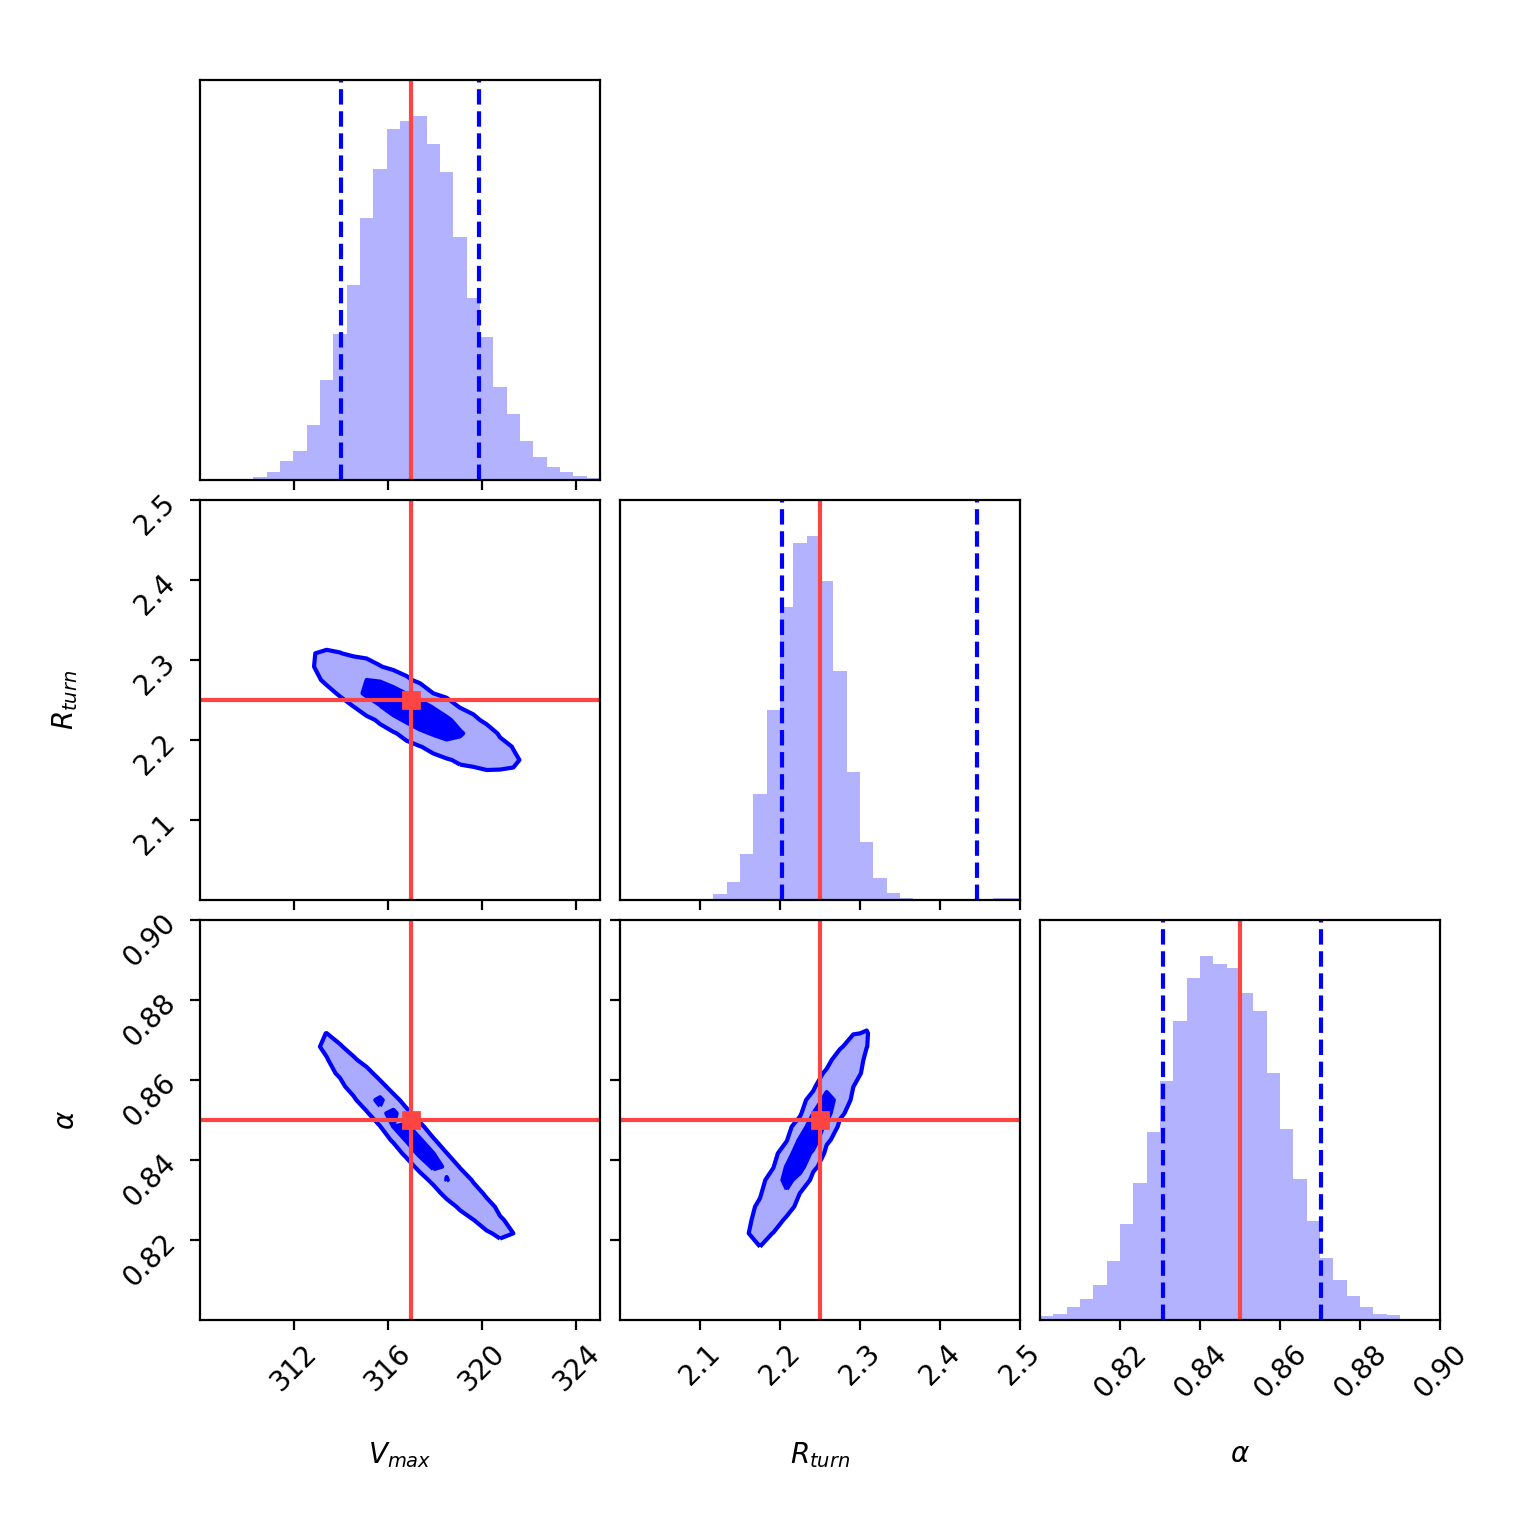

In [31]:
fig = corner.corner(flat_rand_samples, labels=labels_display,
                    range=[(308,325), (2,2.5), (0.8,0.9)], bins=30, #smooth=1,
                    truths=[316.97, 2.25, 0.85], truth_color='#ff4444',
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    color='blue', plot_datapoints=False,
                    fill_contours=True);

In [32]:
model_map_BB = model_vel_map(np.concatenate([pos_params, [316.97, 2.25, 0.85]]), 
                             map_shape, 
                             pix_scale_factor, 
                             'BB')

<IPython.core.display.Javascript object>


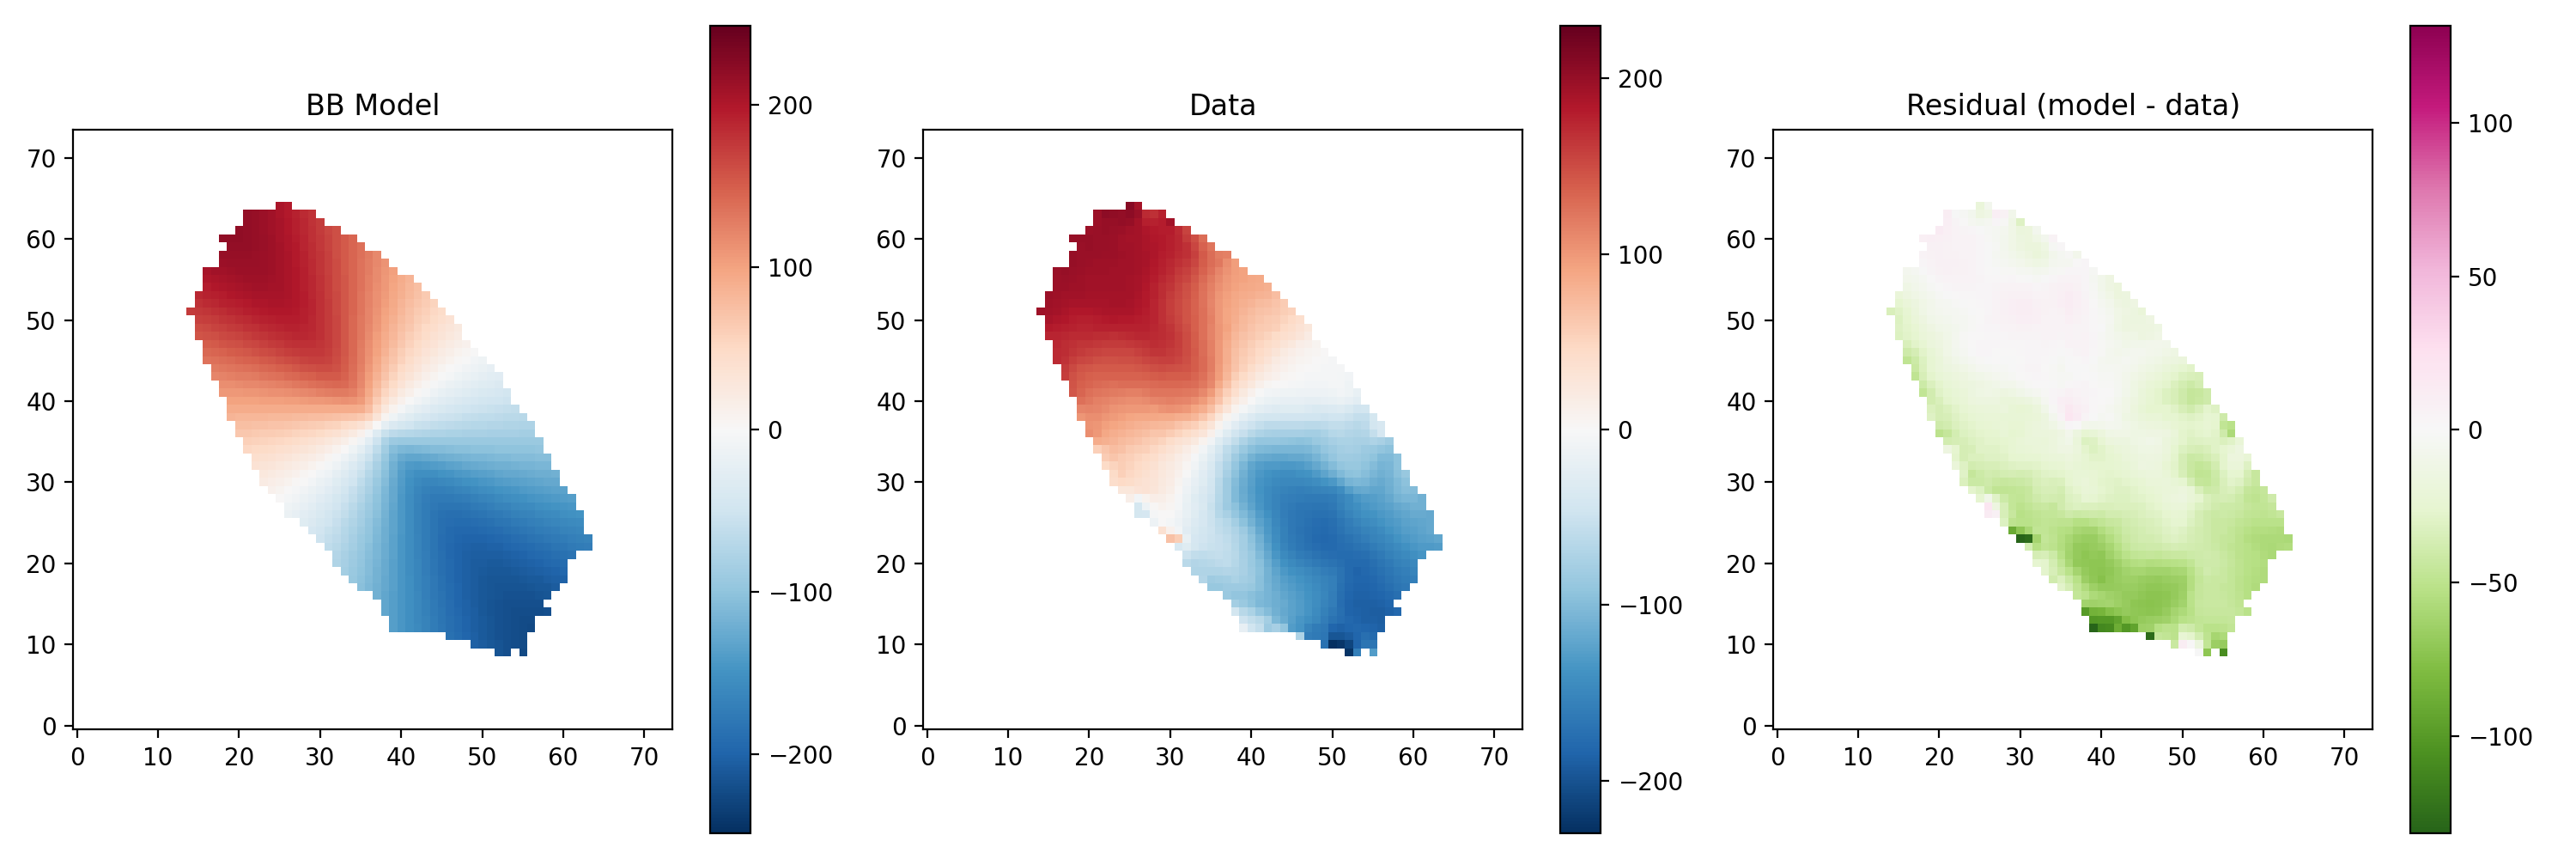

In [34]:
plt.figure(figsize=(15,5))

plt.subplot(131)
extreme1 = np.max(np.abs(model_map_BB))
plt.imshow(ma.array(model_map_BB - v_sys, mask=mHa_vel.mask), 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-extreme1, 
           vmax=extreme1)
plt.colorbar()
plt.title('BB Model')

plt.subplot(132)
extreme2 = np.max(np.abs(mHa_vel))
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme2, vmax=extreme2)
plt.colorbar()
plt.title('Data')

plt.subplot(133)
map_max = np.max(np.abs(model_map_BB - mHa_vel))
plt.imshow(model_map_BB - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-map_max, vmax=map_max)
plt.colorbar()
plt.title('Residual (model - data)')

plt.tight_layout();

# Run MCMC and fit all parameters

In [93]:
pos = best_fit_params + np.random.randn(32,8)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                log_prob, 
                                args=(pix_scale_factor, mHa_vel, mHa_vel_ivar))
sampler.run_mcmc(pos, 10000, progress=True);

 25%|██▍       | 2454/10000 [2:24:15<7:17:04,  3.48s/it]/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in double_scalars
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))
100%|██████████| 10000/10000 [9:36:06<00:00,  3.46s/it]  


#### Plot the chains

In [ ]:
good_walkers = sampler.acceptance_fraction > 0

In [99]:
fig, axes = plt.subplots(8,1, figsize=(10, 16), sharex=True,
                         gridspec_kw={'hspace':0.1})
good_samples = sampler.get_chain()[:,good_walkers,:]

labels_display = [r'$V_{sys}$', r'$i$', r'$x_0$', r'$y_0$', r'$\phi$', r'$V_{max}$', r'$R_{turn}$', r'$\alpha$']
yrange = [(-50,50), (0.5,1.25), (35,40), (35,40), (0,0.5*np.pi), (250,500), (0,6), (0,4)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(good_samples[:10000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,10000), ylim=yrange[i], ylabel=labels_display[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number');

<IPython.core.display.Javascript object>

#### Generate a corner plot

In [96]:
flat_samples = sampler.get_chain(discard=6000, flat=True)

In [108]:
labels = ['v_sys', 'i', 'x_0', 'y_0', 'phi', 'v_max', 'r_turn', 'alpha']
for i, label in enumerate(labels):
    x = np.median(flat_samples[:,i])
    x16, x84 = np.percentile(flat_samples[:,i], [16,84])
    dlo = x - x16
    dhi = x84 - x
    print('{:3s} = {:6.3f} + {:5.3f} - {:5.3f}'.format(label, x, dhi, dlo))

v_sys = 12.564 + 0.370 - 0.833
i   =  1.004 + 0.003 - 0.003
x_0 = 37.797 + 0.030 - 0.033
y_0 = 36.568 + 0.030 - 0.022
phi =  0.717 + 0.002 - 0.002
v_max = 402.032 + 12.474 - 21.825
r_turn =  1.396 + 0.096 - 0.094
alpha =  0.507 + 0.028 - 0.021


<IPython.core.display.Javascript object>


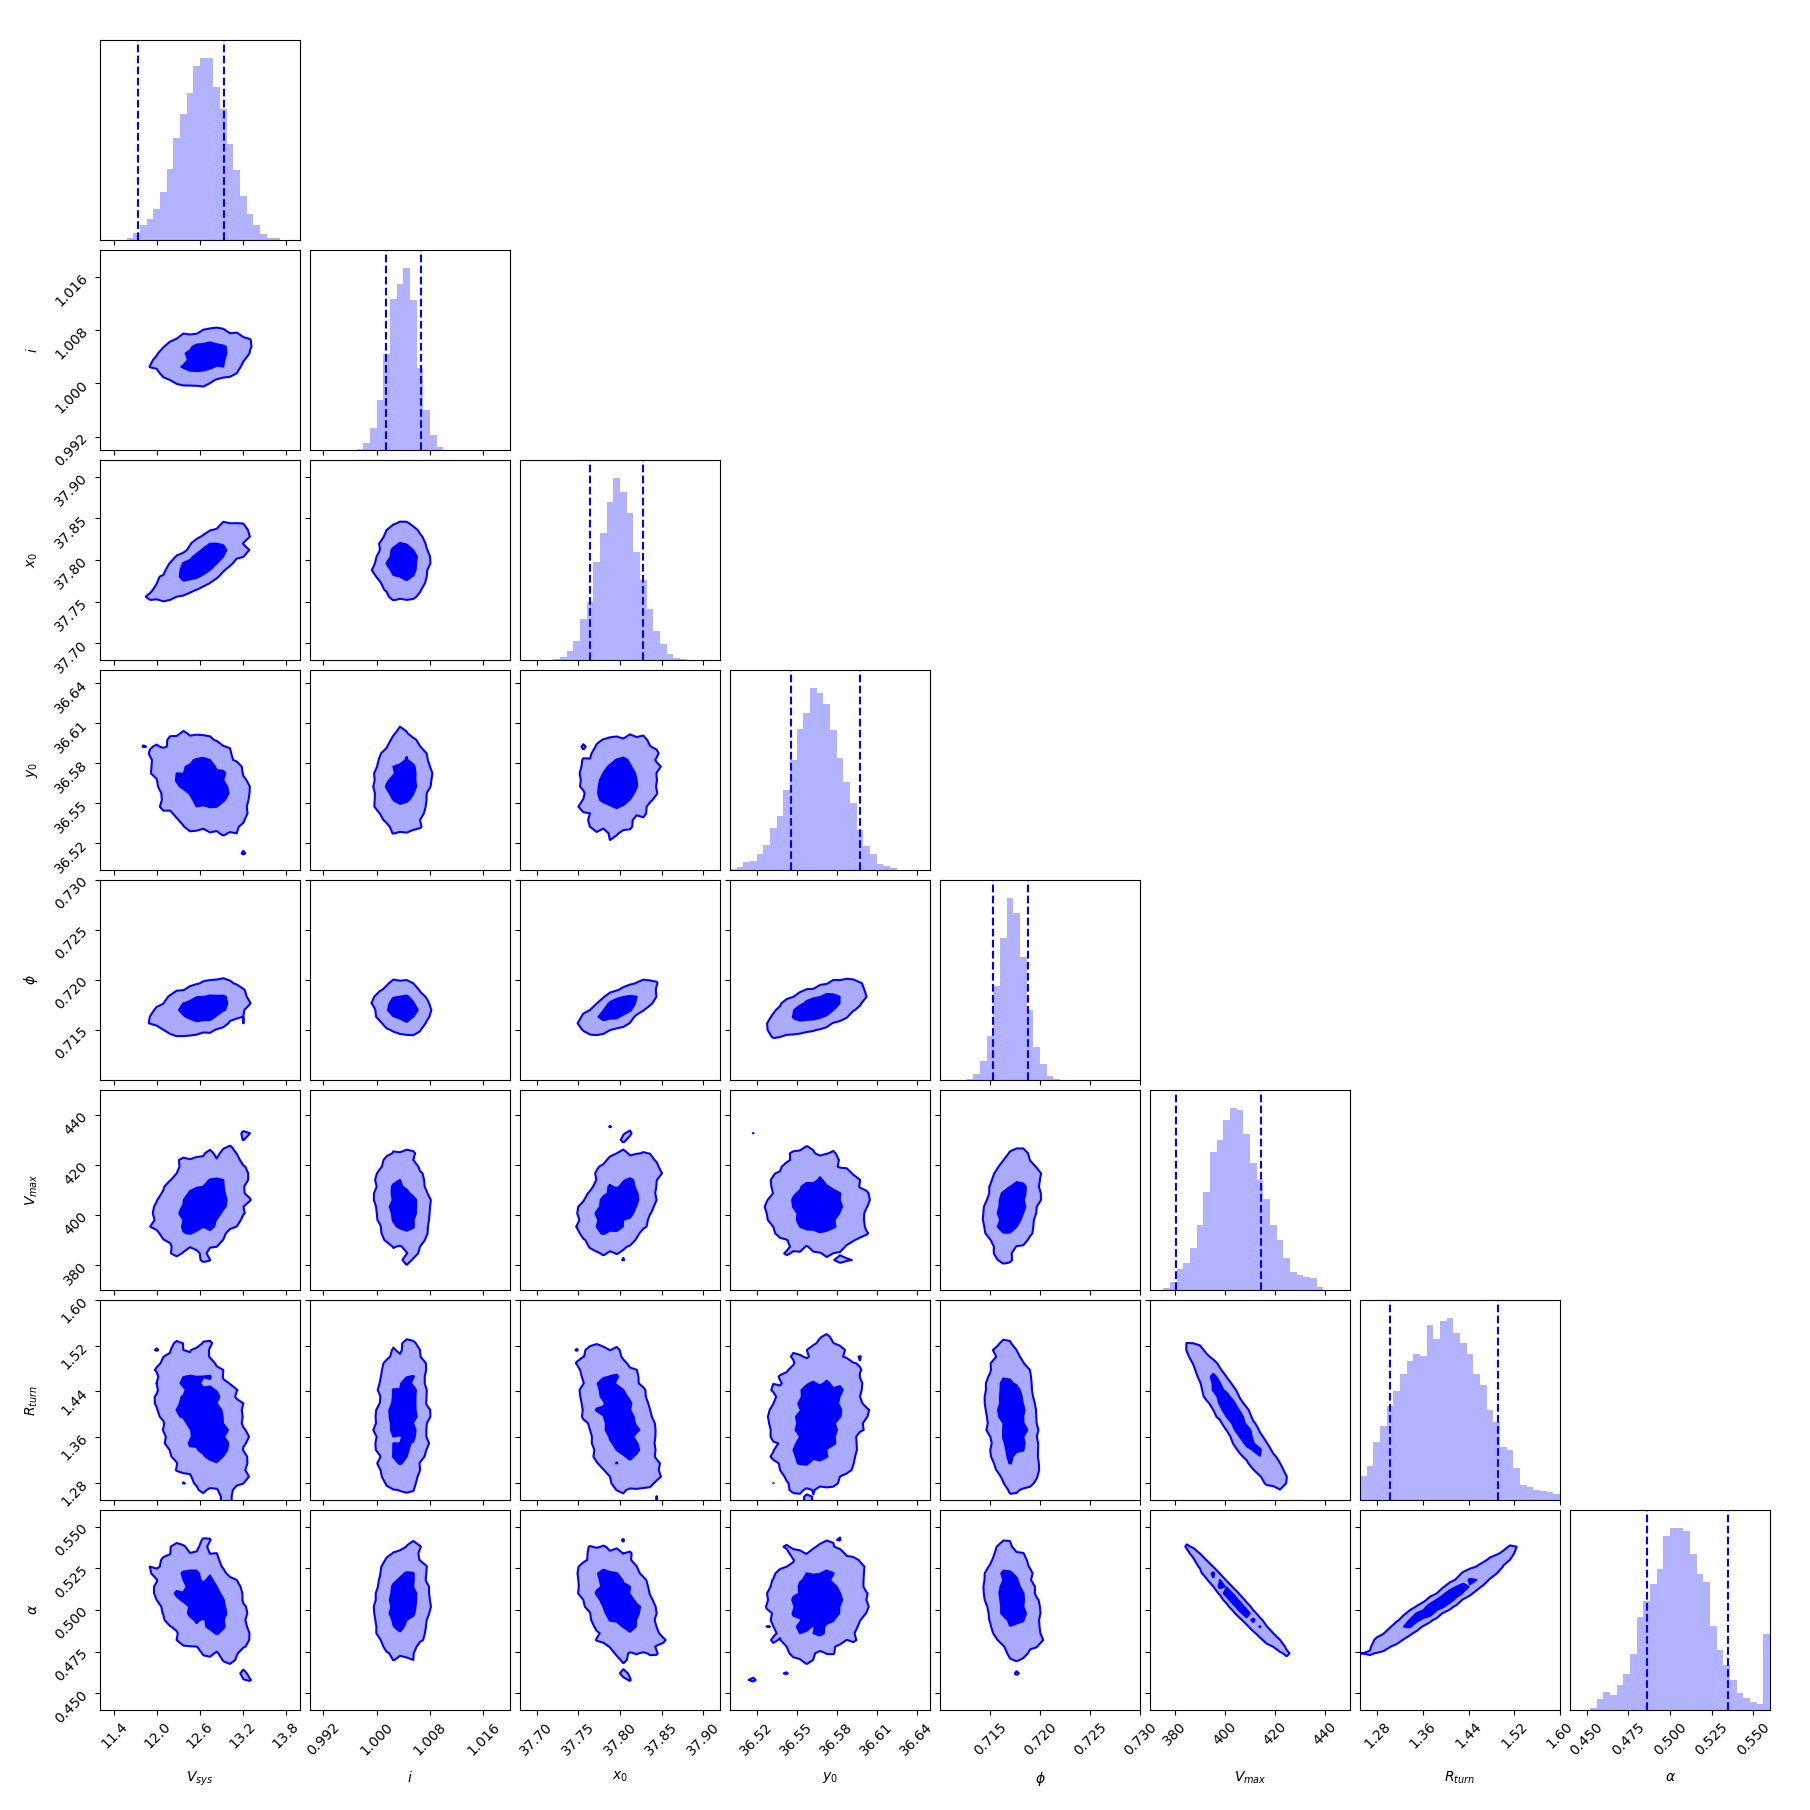

In [112]:
fig = corner.corner(flat_samples, labels=labels_display,
                    #range=yrange, 
                    range=[(11.2,14), (0.99,1.02), (37.68,37.92), (36.5,36.65), (0.71,0.73), (370,450), (1.25,1.6), (0.44,0.56)],
                    bins=30, 
                    #smooth=1,
                    truths=best_fit_params, truth_color='#ff4444',
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    color='blue', plot_datapoints=False,
                    fill_contours=True);

### Resulting velocity map

In [113]:
model_map_BB = model_vel_map([12.564, 1.004, 37.797, 36.568, 0.717, 402.032, 1.396, 0.507], 
                             map_shape, 
                             pix_scale_factor, 
                             'BB')
model_map_BB_1D = model_vel_map(best_fit_params, map_shape, pix_scale_factor, 'BB')

<IPython.core.display.Javascript object>


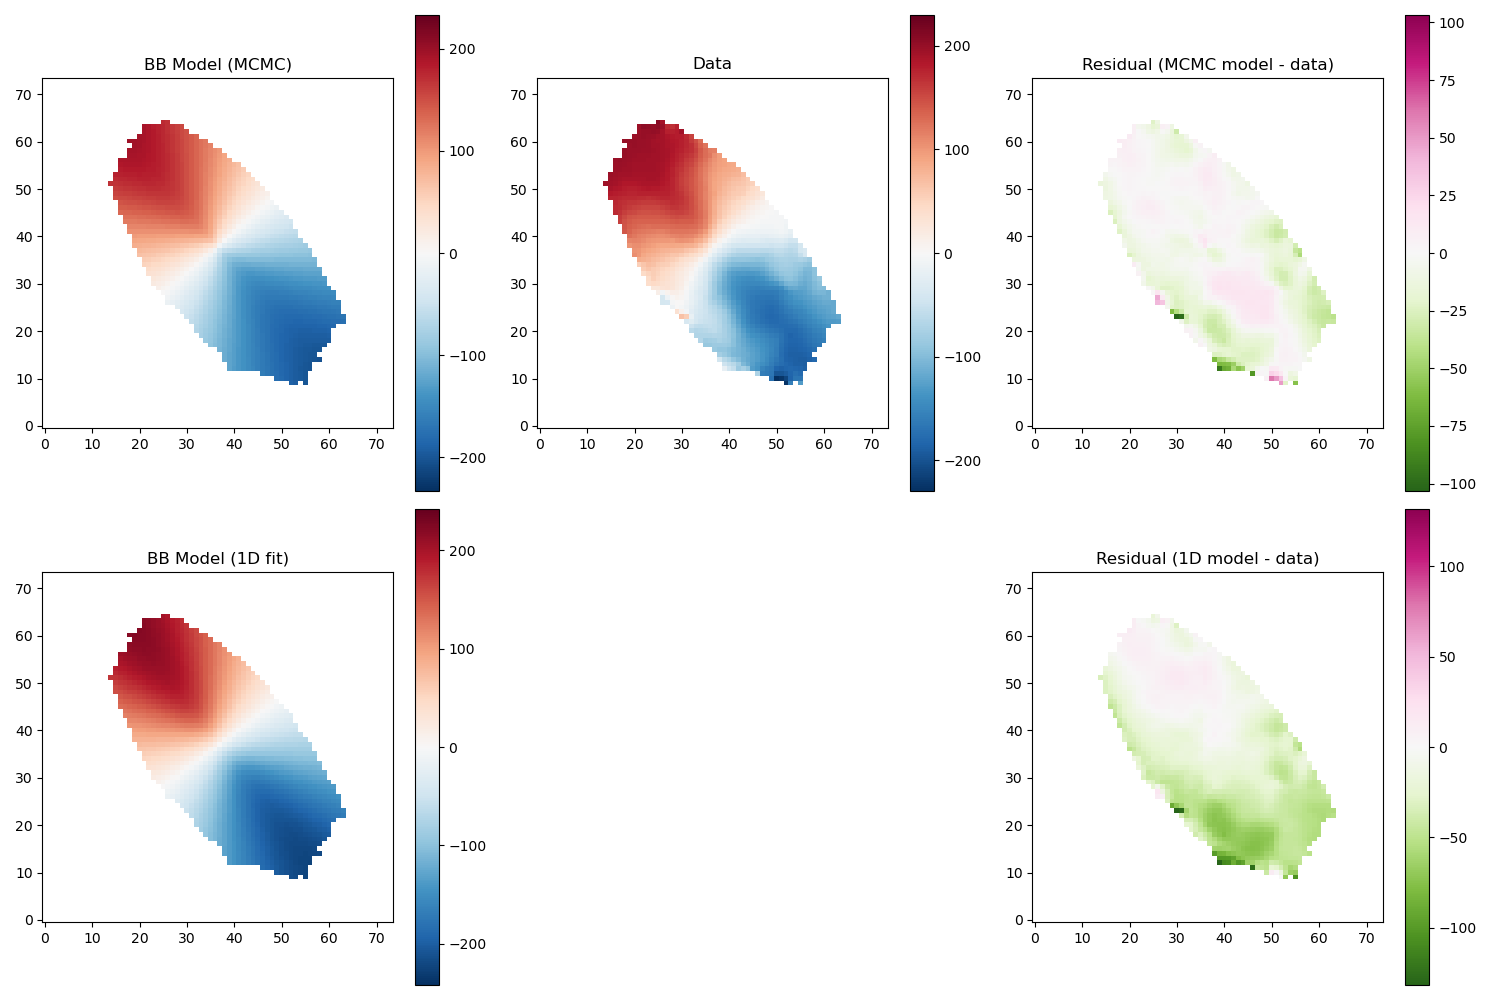

In [115]:
plt.figure(figsize=(15,10))

plt.subplot(231)
model_max = np.max(np.abs(model_map_BB))
plt.imshow(ma.array(model_map_BB - 12.564, mask=mHa_vel.mask), 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-model_max, 
           vmax=model_max)
plt.colorbar()
plt.title('BB Model (MCMC)')

plt.subplot(232)
map_max = np.max(np.abs(mHa_vel))
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-map_max, vmax=map_max)
plt.colorbar()
plt.title('Data')

plt.subplot(233)
diff_max = np.max(np.abs(model_map_BB - mHa_vel))
plt.imshow(model_map_BB - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-diff_max, vmax=diff_max)
plt.colorbar()
plt.title('Residual (MCMC model - data)')

plt.subplot(234)
model1D_max = np.max(np.abs(model_map_BB_1D))
plt.imshow(ma.array(model_map_BB_1D - v_sys, mask=mHa_vel.mask), 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-model1D_max, 
           vmax=model1D_max)
plt.colorbar()
plt.title('BB Model (1D fit)')

plt.subplot(236)
diff1D_max = np.max(np.abs(model_map_BB_1D - mHa_vel))
plt.imshow(model_map_BB_1D - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-diff1D_max, vmax=diff1D_max)
plt.colorbar()
plt.title('Residual (1D model - data)')

plt.tight_layout();